In [37]:
### Datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Skelearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch

from yellowbrick.cluster import silhouette_visualizer



In [17]:
rod = pd.read_excel('./simulation_results.xlsx')
rod.columns

Index(['ID', 'leak_dia', 'leak_distance', 'pressure', 'flow_pipe', 'rod',
       'leak_flow'],
      dtype='object')

In [18]:
#rod.drop(columns=['ID','leak_flow'], inplace=True)
rod_f = rod.drop(columns=['ID','rod'])
rod_rod = rod.drop(columns=['ID','leak_flow'])
rod.drop(columns=['ID'], inplace=True)
rod_nor = preprocessing.scale(rod)

Text(0.5, 0, 'Número de clusters')

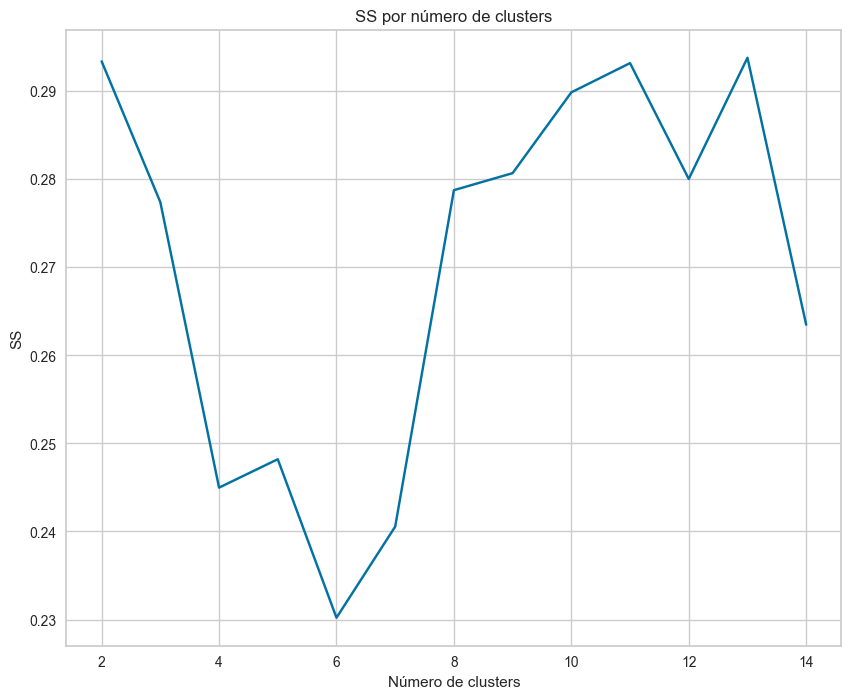

In [19]:
plt.figure(figsize=(10,8))
ss =[]
maxRange = 15
for i in range(2,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rod_nor)
  ss.append(silhouette_score(rod_nor, kmeans.labels_))
plt.plot(range(2,maxRange), ss)
plt.title('SS por número de clusters')
plt.ylabel('SS')
plt.xlabel('Número de clusters')

In [20]:
#Escojo un modelo de 2 cluster por tener el mayor ss
kmeans = KMeans(n_clusters=9, init='k-means++')
model = kmeans.fit(rod_nor)

#Guardo los clusters en el rdb recodificado
rod['Cluster'] = model.labels_

In [21]:
rod.head()

,leak_dia,leak_distance,pressure,flow_pipe,rod,leak_flow,Cluster
0,3.5,15.3333,1190,76.752,31.966865,152.279497,0
1,3.5,7.6667,653,189.540,17.530478,93.460428,4
2,3.5,7.6667,653,58.729,16.312640,81.364855,7
3,3.5,7.6667,1016,76.752,26.121132,129.525084,2
4,3.5,15.3333,1016,189.540,22.906330,127.163212,3


In [22]:
rod.groupby(['Cluster']).describe()['pressure']

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,21.0,1115.428571,88.234104,1016.0,1016.0,1190.0,1190.0,1190.0
1,12.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
2,18.0,1093.333333,88.967939,1016.0,1016.0,1016.0,1190.0,1190.0
3,18.0,1093.333333,88.967939,1016.0,1016.0,1016.0,1190.0,1190.0
4,9.0,693.333333,121.000000,653.0,653.0,653.0,653.0,1016.0
5,14.0,1115.428571,89.358151,1016.0,1016.0,1190.0,1190.0,1190.0
6,21.0,1021.428571,199.867599,653.0,1016.0,1016.0,1190.0,1190.0
7,14.0,653.000000,0.000000,653.0,653.0,653.0,653.0,653.0
8,8.0,698.375000,128.339881,653.0,653.0,653.0,653.0,1016.0


In [23]:
rod.columns

Index(['leak_dia', 'leak_distance', 'pressure', 'flow_pipe', 'rod',
       'leak_flow', 'Cluster'],
      dtype='object')

<Axes: >

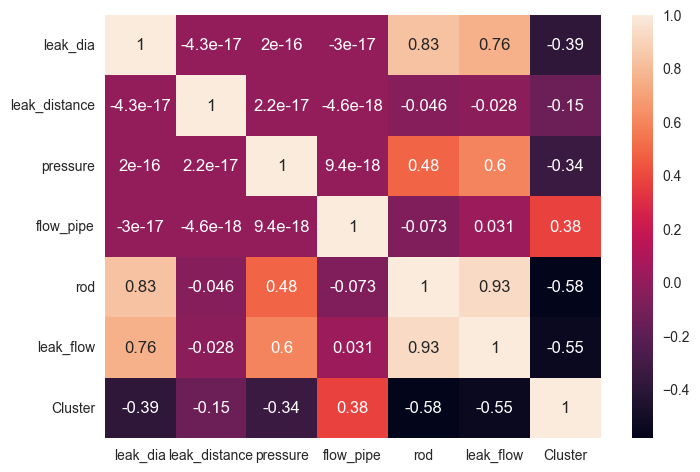

In [24]:
sns.heatmap(rod.corr(), annot=True)

In [32]:
#rod.groupby(['Cluster']).describe()['flow_pipe']

In [29]:
#px.scatter(rod,y='rod', x='pressure', color='Cluster', hover_data='leak_distance')

In [30]:
#px.scatter(rod,y='rod', x='Cluster', color='Cluster', hover_data='leak_distance')

In [31]:
#rod[rod['Cluster'] == 0]

In [35]:
rod_rod.columns

Index(['leak_dia', 'leak_distance', 'pressure', 'flow_pipe', 'rod'], dtype='object')

In [63]:
X, y = rod_rod.drop(columns=["rod"]), rod_rod["rod"] 
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [65]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)

In [66]:
len(Xtrain)

108

In [67]:
len(ytrain)

108

In [68]:
modelo1 = smf.ols(formula='rod~leak_dia+leak_distance+pressure+flow_pipe', data = rod_rod).fit()
print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:                    rod   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     417.6
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           3.96e-73
Time:                        18:30:37   Log-Likelihood:                -332.02
No. Observations:                 135   AIC:                             674.0
Df Residuals:                     130   BIC:                             688.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -29.5944      1.711    -17.294

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
reg = LinearRegression().fit(Xtrain, ytrain)
reg.score(Xtrain, ytrain)
reg.score(Xtest, ytest)
predict = reg.predict(Xtest)
predict
result = pd.DataFrame({
  'y' : ytest,
  'y2' : predict
})
result

In [88]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),    ('linear', LinearRegression(fit_intercept=False))])
model.fit(Xtrain, ytrain)
model.score(Xtrain, ytrain)

predict = model.predict(Xtest)
result = pd.DataFrame({
  'y' : ytest,
  'y2' : predict
})
result


,y,y2
124,14.361671,14.369015
88,18.999514,19.033525
100,19.783897,20.765557
105,42.635636,41.626610
4,22.906330,22.611944
119,8.787098,8.097844
74,5.446510,5.487270
99,34.512408,34.970779
112,14.894760,14.507790
0,31.966865,31.259143


In [93]:
test_results = pd.read_excel('./test_results.xlsx')
X, y = test_results.drop(columns=["rod", 'leak_flow']), test_results["rod"] 
predict = model.predict(X)
result = pd.DataFrame({
  'y' : y,
  'y2' : predict
})
model.score(X,y)

0.9952602145821762